# Import Statements

In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pytz
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl

# Parameters

In [5]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/epod-nyu-delhi-pollution/'
spikes_file = filepath_root+'ankit/spikes.csv'
time_high_file = filepath_root+'ankit/time_high_1H.pkl'
time_low_file = filepath_root+'ankit/time_low_1H.pkl'
space_high_file = filepath_root+'ankit/space_high_3H.pkl'
space_low_file = filepath_root+'ankit/space_low_3H.pkl'

# Data Loading

In [6]:
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/epod-nyu-delhi-pollution/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

# Load Spikes

In [7]:
spikes = pd.read_csv(spikes_file, index_col=0, parse_dates=True)

In [8]:
(spikes==900).sum().sum()+(spikes==910).sum().sum()+(spikes==990).sum().sum()

5243

# Load Temporal Hotspots

In [9]:
with open(time_low_file,'rb') as file:
    thsp_low = pkl.load(file)

In [10]:
with open(time_high_file,'rb') as file:
    thsp_high = pkl.load(file)

# Temporal High

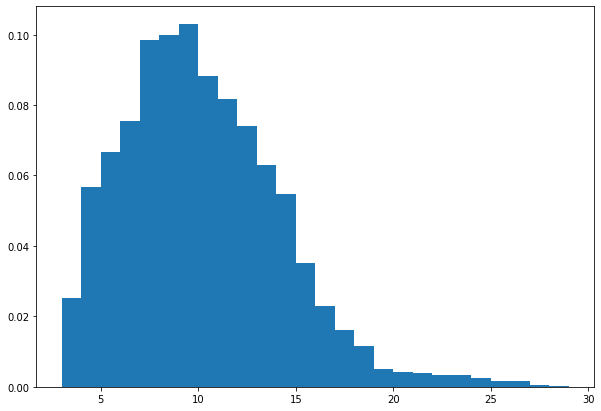

In [11]:
win_size = []
for col in df.columns:
    for i in range(len(thsp_high[col])):
        win_size.append(len(thsp_high[col][i][2]))   

fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(win_size, weights=np.ones(len(win_size))/len(win_size), \
                 bins=range(int(min(win_size)),int(max(win_size)) + 1, 1), cumulative=False)

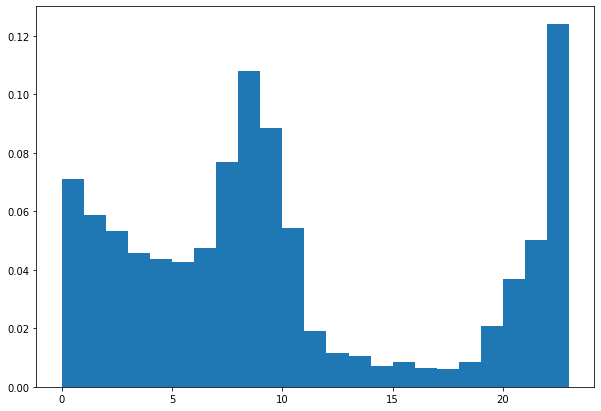

In [12]:
time_list = []
for col in df.columns:
    for entry in thsp_high[col]:
        time_list.append(entry[0].time().hour)
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(time_list, weights=np.ones(len(time_list))/len(time_list), \
                 bins=range(int(min(time_list)),int(max(time_list)) + 1, 1), cumulative=False)

In [13]:
stats[0][12:20].sum()

0.08020450551207725

In [ ]:
old_height = []
for col in df.columns:
    ohsp_index = list(spikes[spikes[col]==900].index) + \
    list(spikes[spikes[col]==910].index) + \
    list(spikes[spikes[col]==990].index)
    for ind in ohsp_index:
        ts_after = ind + datetime.timedelta(hours=3)
        ts_before = ind - datetime.timedelta(hours=3)
        val = df[col].loc[ind]
        val_before = df[col].loc[ts_before]
        val_after = df[col].loc[ts_after]
        old_height.append(val - min(val_before, val_after))

In [ ]:
new_height = []
for col in list(df.columns):
    for i in range(len(thsp_high[col])):
        val_before = df[col].loc[thsp_high[col][i][2][0]]
        val_after = df[col].loc[thsp_high[col][i][2][-1]]
        val = thsp_high[col][i][1]
        new_height.append(val - min(val_before, val_after))

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
stats_old = plt.hist(old_height, weights=np.ones(len(old_height))/len(old_height), \
                 bins=range(int(min(old_height)),int(max(old_height)) + 1, 1), cumulative=False, alpha=0.5,\
                     label='Old Algorithm')
stats_new = plt.hist(new_height, weights=np.ones(len(new_height))/len(new_height), \
                 bins=range(int(min(new_height)),int(max(new_height)) + 1, 1), cumulative=False, alpha=0.5, \
                    label='New Algorithm')
plt.title('Height Distribution')
plt.ylabel('PDF')
plt.xlabel('Height of hospots from base')
plt.legend()
plt.savefig("temp_height_comparison.png")

In [ ]:
matching_temp = {}
for col in df.columns:
    matching_temp[col] = []
    ohsp_index = list(spikes[spikes[col]==900].index) + \
    list(spikes[spikes[col]==910].index) + \
    list(spikes[spikes[col]==990].index)
    for ind in ohsp_index:
        for i in range(len(thsp_high[col])):
            if(ind > thsp_high[col][i][2][0] and ind < thsp_high[col][i][2][-1]):
                matching_temp[col].append([thsp_high[col][i][0], ind])

num_match = 0
for col in df.columns:
    num_match += len(matching_temp[col])
num_match

In [ ]:
matching_temp

In [ ]:
arr = np.array(thsp_high['113E'])
viz_data = arr[arr[:,0]==matching_temp['113E'][2][0]]
df['113E'].loc[viz_data[0][2]]

In [ ]:
x = df['113E'].loc[viz_data[0][2]].index.to_numpy()
ts_before = matching_temp['113E'][2][1] - datetime.timedelta(hours=3)
ts_after = matching_temp['113E'][2][1] + datetime.timedelta(hours=3)
x_or = np.array([ts_before, matching_temp['113E'][2][1], ts_after])
y_or = np.array([df['113E'].loc[ts_before], df['113E'].loc[matching_temp['113E'][2][1]], df['113E'].loc[ts_after]])
y = df['113E'].loc[viz_data[0][2]].to_numpy()
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Temporal Hotspot Instance: '+str(x[0].date())+'__'+str(x[-1].date()) + " (113E)")
for i in range(len(x)):
    x[i] = str(x[i].date().day) + '_' + str(x[i].time())[:-3]
for i in range(len(x_or)):
    x_or[i] = str(x_or[i].date().day) + '_' + str(x_or[i].time())[:-3]
plt.plot(x,y,label='New Algorithm')
plt.plot(x_or,y_or,label='Old Algorithm',color='r',alpha=0.5)
plt.xticks(fontsize=10)
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.savefig('temporal_comp.png')

# Temporal Low

In [ ]:
win_size = []
for col in df.columns:
    for i in range(len(thsp_low[col])):
        win_size.append(len(thsp_low[col][i][2]))   

fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(win_size, weights=np.ones(len(win_size))/len(win_size), \
                 bins=range(int(min(win_size)),int(max(win_size)) + 1, 1), cumulative=False)

In [ ]:
time_list = []
for col in df.columns:
    for entry in thsp_low[col]:
        time_list.append(entry[0].time().hour)
fig, ax = plt.subplots(figsize=(10,7))
stats = plt.hist(time_list, weights=np.ones(len(time_list))/len(time_list), \
                 bins=range(int(min(time_list)),int(max(time_list)) + 1, 1), cumulative=False)

In [ ]:
old_height = []
for col in df.columns:
    ohsp_index = list(spikes[spikes[col]==100].index) + \
    list(spikes[spikes[col]==110].index) + \
    list(spikes[spikes[col]==190].index)
    for ind in ohsp_index:
        ts_after = ind + datetime.timedelta(hours=3)
        ts_before = ind - datetime.timedelta(hours=3)
        val = df[col].loc[ind]
        val_before = df[col].loc[ts_before]
        val_after = df[col].loc[ts_after]
        old_height.append(val - min(val_before, val_after))

In [ ]:
new_height = []
for col in list(df.columns):
    for i in range(len(thsp_low[col])):
        val_before = df[col].loc[thsp_low[col][i][2][0]]
        val_after = df[col].loc[thsp_low[col][i][2][-1]]
        val = thsp_low[col][i][1]
        new_height.append(val - min(val_before, val_after))

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))
stats_old = plt.hist(old_height, weights=np.ones(len(old_height))/len(old_height), \
                 bins=range(int(min(old_height)),int(max(old_height)) + 1, 1), cumulative=False, alpha=0.5,\
                     label='Old Algorithm')
stats_new = plt.hist(new_height, weights=np.ones(len(new_height))/len(new_height), \
                 bins=range(int(min(new_height)),int(max(new_height)) + 1, 1), cumulative=False, alpha=0.5, \
                    label='New Algorithm')
plt.title('Height Distribution')
plt.ylabel('PDF')
plt.xlabel('Height of hospots from base')
plt.legend()
plt.savefig("temp_height_comparison.png")

In [ ]:
matching_temp = {}
for col in df.columns:
    matching_temp[col] = []
    ohsp_index = list(spikes[spikes[col]==100].index) + \
    list(spikes[spikes[col]==110].index) + \
    list(spikes[spikes[col]==190].index)
    for ind in ohsp_index:
        for i in range(len(thsp_low[col])):
            if(ind > thsp_low[col][i][2][0] and ind < thsp_low[col][i][2][-1]):
                matching_temp[col].append([thsp_low[col][i][0], ind])

num_match = 0
for col in df.columns:
    num_match += len(matching_temp[col])
num_match

In [ ]:
matching_temp

In [ ]:
arr = np.array(thsp_low['4BE7'])
viz_data = arr[arr[:,0]==matching_temp['4BE7'][2][0]]
df['4BE7'].loc[viz_data[0][2]]

In [ ]:
x = df['4BE7'].loc[viz_data[0][2]].index.to_numpy()
ts_before = matching_temp['4BE7'][2][1] - datetime.timedelta(hours=3)
ts_after = matching_temp['4BE7'][2][1] + datetime.timedelta(hours=3)
x_or = np.array([ts_before, matching_temp['4BE7'][2][1], ts_after])
y_or = np.array([df['4BE7'].loc[ts_before], df['4BE7'].loc[matching_temp['4BE7'][2][1]], df['4BE7'].loc[ts_after]])
y = df['4BE7'].loc[viz_data[0][2]].to_numpy()
fig, ax = plt.subplots(figsize=(10,7))
plt.title('Temporal Hotspot Instance: '+str(x[0].date())+'__'+str(x[-1].date()) + " (113E)")
for i in range(len(x)):
    x[i] = str(x[i].date().day) + '_' + str(x[i].time())[:-3]
for i in range(len(x_or)):
    x_or[i] = str(x_or[i].date().day) + '_' + str(x_or[i].time())[:-3]
plt.plot(x,y,label='New Algorithm')
plt.plot(x_or,y_or,label='Old Algorithm',color='r',alpha=0.5)
plt.xticks(fontsize=10)
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.savefig('temporal_comp.png')

# Load Spatial Hotspots

In [ ]:
with open(space_high_file,'rb') as file:
    shsp_high = pkl.load(file)
with open(space_low_file,'rb') as file:
    shsp_low = pkl.load(file)

# Spatial High

In [ ]:
(spikes==90).sum().sum() + (spikes==990).sum().sum() + (spikes==190).sum().sum() +\
(spikes==99).sum().sum() + (spikes==91).sum().sum()

In [ ]:
shsp_high_arr = np.array(shsp_high)

In [ ]:
nn_dict = {}
for col in df.columns:
    dist_df = distances.loc[col].sort_values().dropna()
    nn_dict[col] = dist_df

In [ ]:
matching = []
for idx in tqdm(df.index):
    hsps = list(spikes.loc[idx][spikes.loc[idx]==90].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==990].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==190].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==99].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==19].index)
    entry = shsp_high_arr[shsp_high_arr[:,0]==idx]
    if(entry.size):
        hsp = entry[0][1]
        hsp_set = deepcopy(entry[0][2])
        hsp_set.append(hsp)
        set_new = set(hsp_set)
        hsp_set.remove(hsp)
        for i in hsps:
            list_nn = list(nn_dict[i][nn_dict[i]<wsr*1000].index)
            list_nn.append(i)
            set_old = set(list_nn)
            list_nn.remove(i)
            if(set_new.intersection(set_old)):
                matching.append([idx, hsp, hsp_set, i, list_nn])

In [ ]:
len(matching)

In [ ]:
matching

In [ ]:
matching[3]

In [ ]:
hsp_new = locs.loc[[matching[3][1]]+matching[3][2]]
hsp_old = locs.loc[[matching[3][3]]+matching[3][4]]

In [ ]:
hsp_new['Type'] = 'New'
hsp_old['Type'] = 'Old'
inter = set(hsp_new.index).intersection(set(hsp_old.index))
hsp_new['Type'].loc[inter] = 'Both'
hsp_old['Type'].loc[inter] = 'Both'

In [ ]:
locs_map = pd.concat([hsp_new,hsp_old])

In [ ]:
lat_lims = locs.Latitude.min(), locs.Latitude.max()
lon_lims = locs.Longitude.min(), locs.Longitude.max()
lon_center, lat_center = locs.Longitude.mean(), locs.Latitude.mean()

print(lat_lims)
print(lon_lims)
print(lat_center, lon_center)

lat_pad = 1.1 * max(lat_center - lat_lims[0], lat_lims[1] - lat_center)
lon_pad = 1.1 * max(lon_center - lon_lims[0], lon_lims[1] - lon_center)
    
extent = tilemapbase.Extent.from_lonlat(lon_center - lon_pad, 
                                        lon_center + lon_pad, 
                                        lat_center - lat_pad, 
                                        lat_center + lat_pad)
# extent = tilemapbase.Extent.from_lonlat(lon_lims[0], lon_lims[1], lat_lims[0], lat_lims[1])

# extent = extent.to_aspect(1.0)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background
# t = tilemapbase.tiles.Stamen_Toner

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in locs_map.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'New':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=400, label='New Algorithm')
    elif row.Type == 'Old':
        obj2 = ax.scatter(x, y, marker='.', color='b', s=400, label='Old Algorithm')
    else:
        obj3 = ax.scatter(x, y, marker='.', color='g', s=400, label='Intersection')
    # ax.text(x, y, row._3[:2], fontsize=12, color='b', withdash=True)
    ax.text(x, y, row.Index+'('+str(round(df.loc[matching[3][0]][row.Index],3))+')', fontsize=6)

ax.legend((obj1, obj2, obj3), (obj1.get_label(), obj2.get_label(), obj3.get_label()), loc='lower right', ncol=3)
# fig.savefig('locs_map.pdf')
plt.title("Spatial Hotspot Instance: "+str(matching[3][0]))
plt.savefig('spatial_comp.png')

# Spatial Low

In [ ]:
(spikes==10).sum().sum() + (spikes==910).sum().sum() + (spikes==110).sum().sum() +\
(spikes==19).sum().sum() + (spikes==11).sum().sum()

In [ ]:
shsp_low_arr = np.array(shsp_low)

In [ ]:
nn_dict = {}
for col in df.columns:
    dist_df = distances.loc[col].sort_values().dropna()
    nn_dict[col] = dist_df

In [ ]:
matching = []
for idx in tqdm(df.index):
    hsps = list(spikes.loc[idx][spikes.loc[idx]==10].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==910].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==110].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==91].index) + \
    list(spikes.loc[idx][spikes.loc[idx]==11].index)
    entry = shsp_low_arr[shsp_low_arr[:,0]==idx]
    if(entry.size):
        hsp = entry[0][1]
        hsp_set = deepcopy(entry[0][2])
        hsp_set.append(hsp)
        set_new = set(hsp_set)
        hsp_set.remove(hsp)
        for i in hsps:
            list_nn = list(nn_dict[i][nn_dict[i]<wsr*1000].index)
            list_nn.append(i)
            set_old = set(list_nn)
            list_nn.remove(i)
            if(set_new.intersection(set_old)):
                matching.append([idx, hsp, hsp_set, i, list_nn])

In [ ]:
len(matching)

In [ ]:
matching

In [ ]:
matching[0]

In [ ]:
hsp_new = locs.loc[[matching[0][1]]+matching[0][2]]
hsp_old = locs.loc[[matching[0][3]]+matching[0][4]]

In [ ]:
hsp_new['Type'] = 'New'
hsp_old['Type'] = 'Old'
inter = set(hsp_new.index).intersection(set(hsp_old.index))
hsp_new['Type'].loc[inter] = 'Both'
hsp_old['Type'].loc[inter] = 'Both'

In [ ]:
locs_map = pd.concat([hsp_new,hsp_old])

In [ ]:
lat_lims = locs.Latitude.min(), locs.Latitude.max()
lon_lims = locs.Longitude.min(), locs.Longitude.max()
lon_center, lat_center = locs.Longitude.mean(), locs.Latitude.mean()

print(lat_lims)
print(lon_lims)
print(lat_center, lon_center)

lat_pad = 1.1 * max(lat_center - lat_lims[0], lat_lims[1] - lat_center)
lon_pad = 1.1 * max(lon_center - lon_lims[0], lon_lims[1] - lon_center)
    
extent = tilemapbase.Extent.from_lonlat(lon_center - lon_pad, 
                                        lon_center + lon_pad, 
                                        lat_center - lat_pad, 
                                        lat_center + lat_pad)
# extent = tilemapbase.Extent.from_lonlat(lon_lims[0], lon_lims[1], lat_lims[0], lat_lims[1])

# extent = extent.to_aspect(1.0)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background
# t = tilemapbase.tiles.Stamen_Toner

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in locs_map.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'New':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=400, label='New Algorithm')
    elif row.Type == 'Old':
        obj2 = ax.scatter(x, y, marker='.', color='b', s=400, label='Old Algorithm')
    else:
        obj3 = ax.scatter(x, y, marker='.', color='g', s=400, label='Intersection')
    # ax.text(x, y, row._3[:2], fontsize=12, color='b', withdash=True)
    ax.text(x, y, row.Index+'('+str(round(df.loc[matching[0][0]][row.Index],3))+')', fontsize=6)

ax.legend((obj1, obj2, obj3), (obj1.get_label(), obj2.get_label(), obj3.get_label()), loc='lower right', ncol=3)
# fig.savefig('locs_map.pdf')
plt.title("Spatial Hotspot Instance: "+str(matching[0][0]))
plt.savefig('spatial_comp.png')